# Previsão de vazão de rios

Utilizam-se os dados de furnas e de camargos.

Importam-se as seguintes bibliotecas externas:

 - pandas
 - matplotlib
 - statsmodels
 - sklearn
 - seaborn
 - numpy
 - keras
 - theano
 - pmdarima >= 1.3.0
 
A aplicação jupyternotify é usada para notificar o fim da execução do código

In [1]:
%load_ext jupyternotify
%autonotify -a 10

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import pickle

import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.arima import auto_arima
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (15, 10)

Definição de constantes:

In [3]:
janela = 12
adicional_reco = 60
teste = 120
fracao_valida = 0.2

Funções auxiliadoras para o cálculo de métricas, demonstração gráficas e montagem das matrizes

In [4]:
indices_teste_seco = [k for k in range(-teste,0) if k%-12 in [-8,-7,-6,-5,-4,-3]]
indices_teste_umido = [k for k in range(-teste,0) if k%-12 in [0,-11,-10,-9,-2,-1]]

def imprime_metricas(real, predito, fator_normalizacao, teste=False):
    print('RMSE = ', np.sqrt(np.mean(np.square(predito - real)))*fator_normalizacao, end=', ')
    print('MSE = ', metrics.mean_squared_error(real, predito)*fator_normalizacao**2 , end=', ')
    print('MAPE = ', 100*np.mean(np.abs(predito-real)/real), '%', end=', ')
    print('MAE = ', metrics.mean_absolute_error(real, predito)*fator_normalizacao , end=', ')
    print('R = ', metrics.r2_score(real, predito))
    if teste:
        ps = predito[indices_teste_seco]
        rs = real[indices_teste_seco]
        pu = predito[indices_teste_umido]
        ru = real[indices_teste_umido]
        print('MAPE seco = ', 100*np.mean(np.abs(ps-rs)/rs), '%')
        print('MAPE umido = ', 100*np.mean(np.abs(pu-ru)/ru), '%')

Carregamento incial dos dados

In [5]:
furnas = np.array([float(a) for a in open('dados/furnas.csv', 'r').read().split('\n') if a])
camargos = np.array([float(a) for a in open('dados/camargos.csv', 'r').read().split('\n') if a])
assert(len(furnas) == len(camargos))
valida = int((len(furnas) - teste - janela) * fracao_valida)
treino = len(furnas) - teste - valida - janela
fatores_normalizacao = [furnas[:treino].max(), camargos[:treino].max()]
furnas /= fatores_normalizacao[0]
camargos /= fatores_normalizacao[1]

print('Treino, ', treino)
print('Validação, ', valida)
print('Teste, ', teste)
print('Total, ', len(furnas) - janela)

Treino,  682
Validação,  170
Teste,  120
Total,  972


Verificação da correlação entre as duas séries temporais

In [6]:
np.corrcoef(furnas, camargos)

array([[1.       , 0.9530124],
       [0.9530124, 1.       ]])

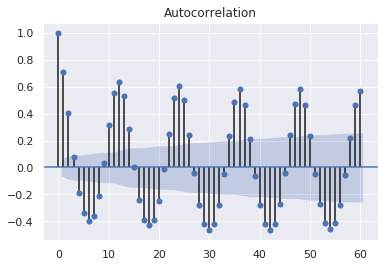

In [7]:
plot_acf(furnas, lags=60)
plt.rcParams["figure.figsize"] = (14, 8)

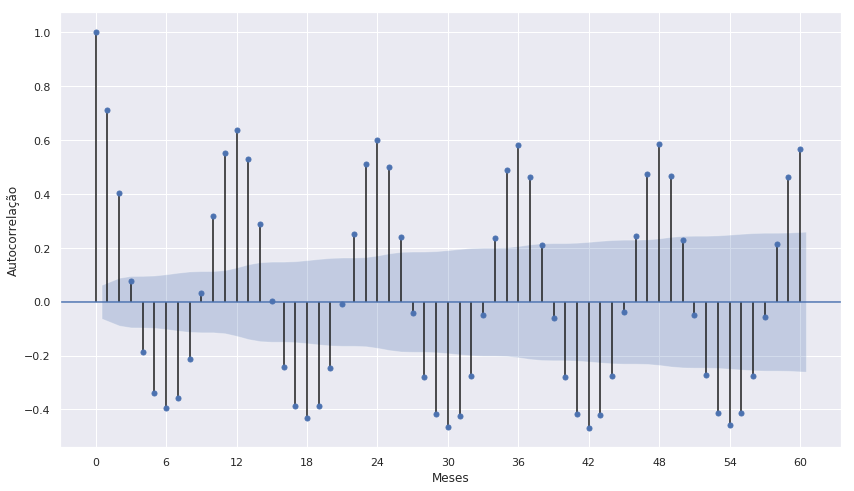

In [8]:
plot_acf(furnas, lags=60)
plt.xticks(np.arange(0, 61, step=6))
plt.title('')
plt.ylabel('Autocorrelação')
plt.xlabel('Meses')
plt.show()

## ARIMA

Análise inicial dos dados por decomposição aditiva

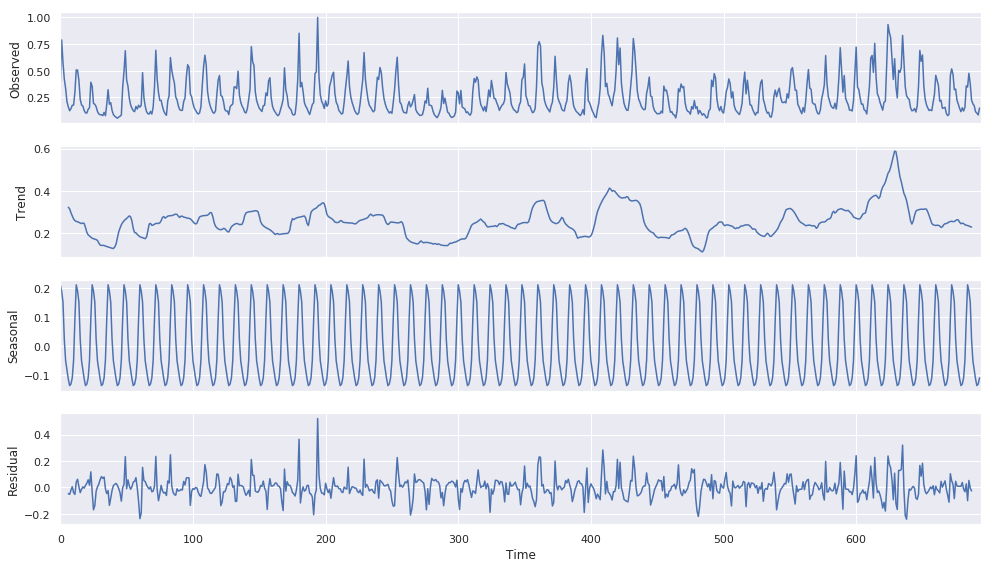

In [9]:
decomposicao = seasonal_decompose(furnas[:-teste-valida], model='additive', freq=12)
decomposicao.plot()
plt.show()

## Furnas

Treinamento completo do modelo ARIMA no conjunto de treinamento e validação (com escolha automática dos hiperparâmetros), para avaliação final no teste.

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-1395.941, BIC=-1372.133, Fit time=4.262 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-668.918, BIC=-659.395, Fit time=0.583 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=-1447.481, BIC=-1428.435, Fit time=2.294 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-1257.691, BIC=-1238.645, Fit time=2.238 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-1300.377, BIC=-1286.093, Fit time=0.597 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=-1517.029, BIC=-1493.221, Fit time=11.739 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=-1674.260, BIC=-1645.690, Fit time=15.241 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=-1353.319, BIC=-1329.511, Fit time=27.530 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=-1671.995, BIC=-1638.664, Fit time=18.627 seconds
Fit ARIM

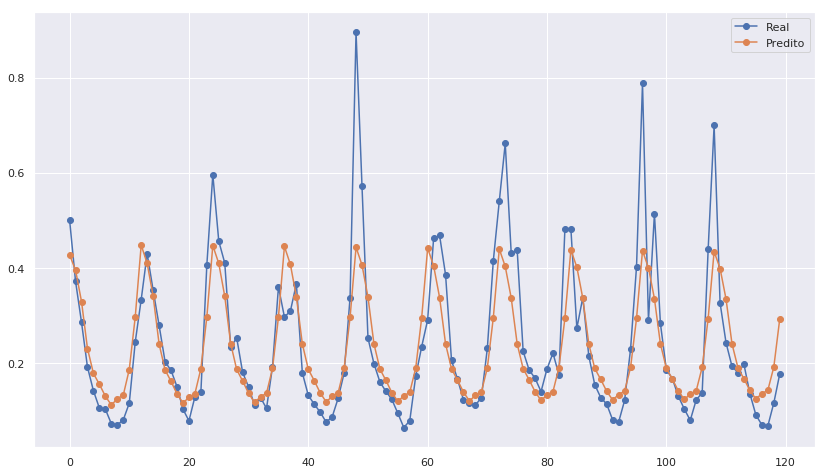

RMSE =  345.7894585945874, MSE =  119570.34967513788, MAPE =  27.825548027679968 %, MAE =  232.9515863715019, R =  0.6805085430411373


ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 2),
   out_of_sample_size=170, scoring='mae', scoring_args={},
   seasonal_order=(2, 0, 2, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

<IPython.core.display.Javascript object>

In [10]:
modelo_arima = auto_arima(furnas[:-teste], start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,
          d=0, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True, out_of_sample_size=valida, scoring='mae')
print(modelo_arima.aic())
plt.plot(furnas[-teste:], '-o')
plt.plot(modelo_arima.predict(n_periods=teste), '-o')
plt.legend(['Real', 'Predito'], loc='upper right')
plt.show()
imprime_metricas(furnas[-teste:], modelo_arima.predict(n_periods=teste), fatores_normalizacao[0])
modelo_arima

Retreina o modelo no conjunto de validação inclusive e cada nova previsão, também realiza um retreino

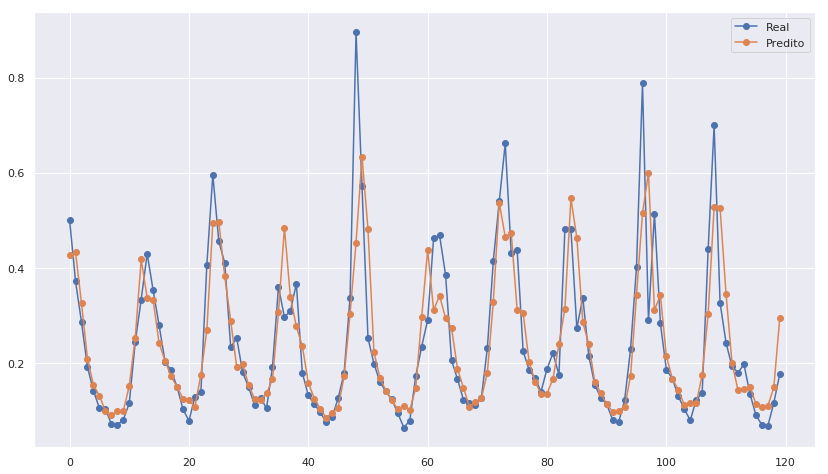

RMSE =  337.37217420311674, MSE =  113819.98392653815, MAPE =  22.097346245335 %, MAE =  212.29910558086254, R =  0.6958734954399382
MAPE seco =  17.488485930061515 %
MAPE umido =  26.706206560608486 %


<IPython.core.display.Javascript object>

In [11]:
modelo_arima.fit(furnas[:-teste])
modelo_arima_predicoes = []

for proxima_entrada in furnas[-teste:]:
    estimado = modelo_arima.predict(n_periods=1).tolist()[0]
    modelo_arima_predicoes.append(estimado)
    modelo_arima.update(proxima_entrada)

plt.plot(furnas[-teste:], '-o')
plt.plot(modelo_arima_predicoes, '-o')
plt.legend(['Real', 'Predito'], loc='upper right')
plt.show()
imprime_metricas(furnas[-teste:], np.array(modelo_arima_predicoes), fatores_normalizacao[0], True)

## Camargos

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-1505.450, BIC=-1481.642, Fit time=1.962 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-852.310, BIC=-842.787, Fit time=0.206 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=-1544.965, BIC=-1525.919, Fit time=2.328 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-1391.272, BIC=-1372.226, Fit time=1.584 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=-1427.133, BIC=-1412.848, Fit time=0.479 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=-1613.862, BIC=-1590.055, Fit time=7.485 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=-1768.203, BIC=-1739.633, Fit time=8.888 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=-1486.312, BIC=-1462.505, Fit time=7.194 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=-1774.813, BIC=-1741.482, Fit time=13.493 seconds
Fit ARIMA: 

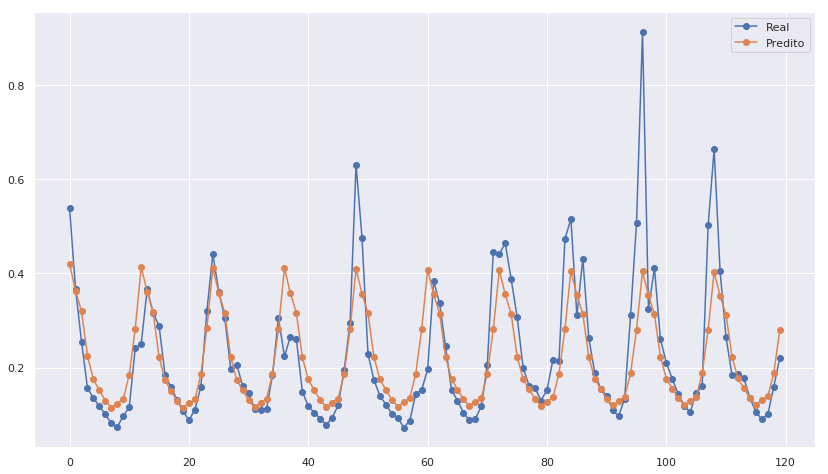

RMSE =  49.58406023983881, MSE =  2458.5790298679644, MAPE =  23.658673711468843 %, MAE =  30.483601010558225, R =  0.6439714830540202


ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(2, 0, 0),
   out_of_sample_size=170, scoring='mae', scoring_args={},
   seasonal_order=(2, 0, 2, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

<IPython.core.display.Javascript object>

In [12]:
modelo_arima_camargos = auto_arima(camargos[:-teste], start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,
          d=0, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True, out_of_sample_size=valida, scoring='mae')
print(modelo_arima_camargos.aic())
plt.plot(camargos[-teste:], '-o')
plt.plot(modelo_arima_camargos.predict(n_periods=teste), '-o')
plt.legend(['Real', 'Predito'], loc='upper right')
plt.show()
imprime_metricas(camargos[-teste:], modelo_arima_camargos.predict(n_periods=teste), fatores_normalizacao[1])
modelo_arima_camargos

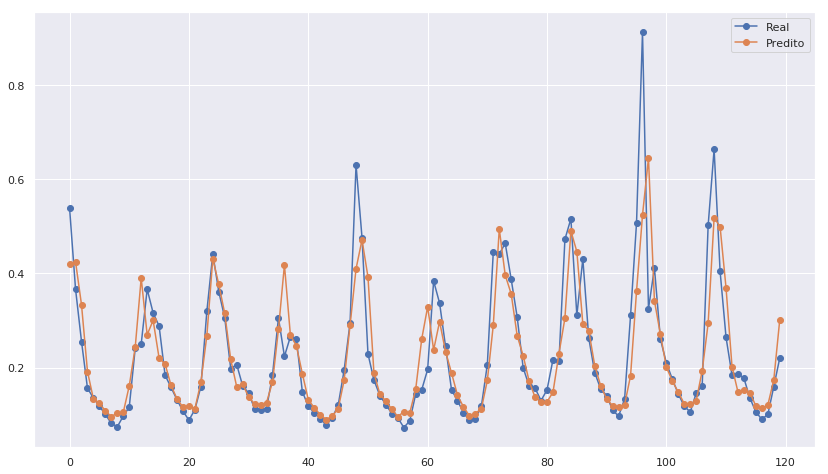

RMSE =  45.31775584780749, MSE =  2053.6989950814905, MAPE =  17.4835052014633 %, MAE =  26.041249372202067, R =  0.702602438811341
MAPE seco =  11.510855642921989 %
MAPE umido =  23.456154760004612 %


<IPython.core.display.Javascript object>

In [13]:
modelo_arima_camargos.fit(camargos[:-teste])
modelo_arima_camargos_predicoes = []

for proxima_entrada in camargos[-teste:]:
    estimado = modelo_arima_camargos.predict(n_periods=1).tolist()[0]
    modelo_arima_camargos_predicoes.append(estimado)
    modelo_arima_camargos.update(proxima_entrada)

plt.plot(camargos[-teste:], '-o')
plt.plot(modelo_arima_camargos_predicoes, '-o')
plt.legend(['Real', 'Predito'], loc='upper right')
plt.show()
imprime_metricas(camargos[-teste:], np.array(modelo_arima_camargos_predicoes), fatores_normalizacao[1], True)